In [4]:
import gym
import cv2

import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from model import DuelCNN
from collections import deque
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

In [5]:
DEVICE = 'mps'
torch.manual_seed(113)
random.seed(113)
class Agent:

    def __init__(self, env, max_memory, batch_size, lr, epsilon, epsilon_rate, gamma, iterations):

        self.state_size_h = env.observation_space.shape[0]
        self.state_size_w = env.observation_space.shape[1]
        self.state_size_c = env.observation_space.shape[2]

        self.action_size = env.action_space.n

        # результирующее изображение
        self.target_h = 84 # Height after process
        self.target_w = 84  # Widht after process
        self.crop_dim = [30, -16 , 0, self.state_size_w]  # Cut

        self.epsilon = epsilon
        self.epsilon_rate = epsilon_rate

        self.batch_size = batch_size

        self.gamma = gamma  # Коэффициент обесценивания
        self.lr = lr

        self.n_games = 0

        self.max_memory = max_memory # максимальный объем памяти
        self.memory = deque(maxlen=self.max_memory)

        self.model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        lf = lambda x: (1 - x / (iterations - 1)) * (1 - 0.01) + 0.01
        self.sheduler = lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lf)
        self.criterion = nn.MSELoss()

    def preProcess(self, image):
        frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # To grayscale
        frame = frame[self.crop_dim[0]:self.crop_dim[1], self.crop_dim[2]:self.crop_dim[3]]  # Cut 20 px from top

        frame = cv2.resize(frame, (self.target_w, self.target_h))  # Resize
        plt.imshow(frame)
        frame = frame / 255
        return frame

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))  # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > self.max_memory * 0.2:
            # случайно выбираем пачку из памяти
            mini_sample = random.sample(self.memory, self.batch_size)
            states, actions, rewards, next_states, dones = zip(*mini_sample)
            states = np.array(states)
            next_states = np.array(next_states)
            actions = np.array(actions)
            dones = np.array(dones)
            return self.train_step(states, actions, rewards, next_states, dones)
        return 0, 0
        #else:
        #    # или используем всю память
        #    mini_sample = self.memory


    def train_short_memory(self, state, action, reward, next_state, done):
        self.train_step(state, action, reward, next_state, done)

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float, device=DEVICE)
        next_state = torch.tensor(next_state, dtype=torch.float, device=DEVICE)
        action = torch.tensor(action, dtype=torch.long, device=DEVICE)
        reward = torch.tensor(reward, dtype=torch.float, device=DEVICE)#.unsqueeze(-1)

        done = torch.tensor(done, dtype=torch.float,device=DEVICE)
        # получили функцию ценности действий для текущего состояния/
        # оценка текущего состояния
        pred_q = self.model(state)
        pred_q_next_states = self.model(next_state)
        target = self.target_model(next_state)

        # выбрать полезности по номеру совершенного действия
        selected_q_value = pred_q.gather(1, action.unsqueeze(1)).squeeze(1)
        # выбрать номера действий по результатам следующего состояния
        r = pred_q_next_states.max(1)[1]
        # из таргета выбираем те полезности которые соответствуют действиям предсказанным для следующего состояния
        next_states_target_q_value = target.gather(1, r.unsqueeze(1)).squeeze(1)
        expected_q_value = reward + self.gamma * next_states_target_q_value * (1 - done)  # применили формулу беллмана

        #кусок если хотим работать с полнымит векторами действий вида BxN_действий
        #max_q = torch.max(pred_q_next_states, -1)[0].unsqueeze(1)
        #td = reward + self.gamma * max_q * (1-done)
        #td = torch.where(done, reward, td)
        # для все action выбранных на текущих состояниях - корректируем их полезности на td Q-Q_
        #actions_to_correct_Q = torch.argmax(action, axis=-1).unsqueeze(1)
        #target = target.scatter(1, actions_to_correct_Q, td)

        self.optimizer.zero_grad()
        #loss = self.criterion(pred_q, target.detach())
        loss = self.criterion(selected_q_value, expected_q_value.detach())
        loss.backward()
        self.optimizer.step()
        return loss.item(), torch.max(pred_q).item()

    def act(self, state):
        if random.uniform(0, 1) > self.epsilon:
            state = torch.tensor(state, dtype=torch.float, device=DEVICE).unsqueeze(0)
            q_values = self.model(state)  # (1, action_size)
            action = torch.argmax(q_values).item()
        else:
            action = random.randrange(self.action_size)
        return action


In [6]:
def train(iterations, lr, memory_size, batch_size, epsilon, epsilon_rate, gamma):
    plot_scores = []
    plot_mean_scores = []
    plot_mean_100 = []
    num_steps_by_game = []

    total_score = 0
    record = -20
    score = 0
    total_step = 0
    episode_steps = 0
    env = gym.make("Breakout-v4")#, render_mode='human')

    agent = Agent(env, memory_size, batch_size, lr, epsilon, epsilon_rate, gamma, iterations)
    #agent.model = torch.load("./model/model.pth")
    #agent.target_model.load_state_dict(agent.model.state_dict())
    #agent.target_model.eval()

    agent
    state, _= env.reset(seed=113)
    #plt.imshow(state)
    state = agent.preProcess(state)
    state = np.stack((state, state, state, state)) ## так как не знаем вектора движения - то даем последовательность кадров

    startTime = time.time()
    total_max_q_val = 0  # Total max q vals # Total reward for each episode
    total_loss = 0
    last_100_ep_reward = deque(maxlen=100)

    while agent.n_games < iterations:

        action = agent.act(state)
        next_state, reward, done, info, _ = env.step(action)
        next_state = agent.preProcess(next_state)
        next_state = np.stack((next_state, state[0], state[1], state[2])) #новый кадр-состояние в начало
        # если хотим работать с полными векторами действий
        act_full = np.zeros(agent.action_size)
        act_full[action] = 1

        agent.remember(state, action, reward, next_state, done)
        score += reward
        state = next_state

        episode_steps += 1
        total_step += 1


        if total_step % 1000 == 0:
            if agent.epsilon > 0.07:
                agent.epsilon = agent.epsilon * epsilon_rate
            agent.target_model.load_state_dict(agent.model.state_dict())

        if episode_steps % 4 == 0:
            loss, max_q_val = agent.train_long_memory()
            total_loss += loss
            total_max_q_val += max_q_val

        if done:
            currentTime = time.time()  # Keep current time
            time_passed = currentTime - startTime
            agent.sheduler.step()
            agent.n_games += 1
            if score > record:
                record = score
                agent.model.save()

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            num_steps_by_game.append(episode_steps)

            last_100_ep_reward.append(score)
            avg_100 = sum(last_100_ep_reward) / len(last_100_ep_reward)
            plot_mean_100.append(avg_100)
            avg_max_q_val = total_max_q_val / episode_steps
            print('Game', agent.n_games, 'Score', score,
                  f'Loss: {total_loss:.2f}',
                  f"Mean_score:{mean_score: .2f}",
                  f'Mean_by_100: {avg_100:.2f}',              #"TotalScore:", total_score,
                  f'Duration: {time_passed:.2f}',
                  f'Epsilon: {agent.epsilon: .2f}',
                  "Episode_steps:", episode_steps,
                  "Total_steps:", total_step,
                  f'avg_q_val: {avg_max_q_val:.2f}', )

            score = 0
            episode_steps = 0
            total_max_q_val = 0  # Total max q vals
            total_loss = 0

            state, _ = env.reset(seed=113)
            state = agent.preProcess(state)
            state = np.stack((state, state, state, state))

            agent.target_model.load_state_dict(agent.model.state_dict())
            startTime = time.time()

    fig = plt.figure()
    ax = plt.subplot(111)
    x = np.arange(agent.n_games)
    ax.plot(x, plot_scores, label="Reward")
    ax.plot(x, plot_mean_scores, label="Mean_reward")
    ax.plot(x, plot_mean_100, label="Mean_reward_Last100")
    ax.legend()
    fig.savefig('plot_breakout.png')

    with open(r'./reward.txt', 'w') as fp:
        for item in plot_scores:
            # write each item on a new line
            fp.write("%s\n" % item)
        print('Done')

    with open(r'./mean_reward.txt', 'w') as fp:
        for item in plot_mean_scores:
            # write each item on a new line
            fp.write("%s\n" % item)
        print('Done')

In [7]:
#train(iterations=1500, lr=0.001, memory_size=50000, batch_size=64, epsilon=0.95, epsilon_rate=0.99, gamma=0.97)

![Динамика обучения](plot_breakout1.png)

In [8]:
import io 
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML
def show_video(folder="./video"):
    mp4list = glob.glob(folder + '/*.mp4')
    print (mp4list)
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=lambda x: x[-15:], reverse=True)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

/Users/vampire/miniforge3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video ./video/vid.mp4.
Moviepy - Writing video ./video/vid.mp4



Moviepy - Done !
Moviepy - video ready ./video/vid.mp4
['./video/vid.mp4']


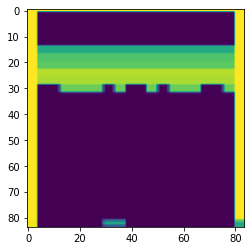

In [13]:

from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob


env = gym.make('Breakout-v4', render_mode='rgb_array')
vid = video_recorder.VideoRecorder(env=env, path="./video/vid.mp4")

done = False

agent = Agent(env, 50000, 64, 0.00001, 0.05, 0.99, 0.97, 10)

state, _ = env.reset(seed=113)
state = agent.preProcess(state)
state = np.stack((state, state, state, state))
agent.model = torch.load("./model/model.pth")

while True:
    action = agent.act(state)
    next_state, reward, done, info, _ = env.step(action)
    next_state = agent.preProcess(next_state)
    next_state = np.stack((next_state, state[0], state[1], state[2]))
    #startrender = time.time()
    vid.capture_frame()
    #print ("env.step " , (stopsim - startsim))
    #print ("env.render " , (stoprender - startrender))
    state = next_state
    if done:
        break;
env.close()
vid.close()
show_video()